In [16]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lib_FM import *
import random
import time
import pickle
from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
random.seed(10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### READING THE DATASET

In [17]:
df=pd.read_csv('./fairlymade_products_impacts.csv')
df.columns

Index(['study_id', 'product_type', 'nb_components', 'composition',
       'raw_material_country', 'weaving_country', 'dyeing_country',
       'manufacturing_country', 'plane_in_transports', 'climate_change',
       'resource_use_fossils'],
      dtype='object')

### ENCODING CATEGORICAL VARIABLES AND BUILDING TRAIN/VALIDATION DATASETS

In [18]:
categorical_features=['product_type','nb_components']
multi_valued_features=['composition','raw_material_country','weaving_country','dyeing_country','manufacturing_country']
boolean_features=['plane_in_transports']
numerical_features=[]

FED=FeaturesEncoderDecoder(categorical_features=categorical_features,
                           multi_valued_features=multi_valued_features,
                           boolean_features=boolean_features,
                           numerical_features=numerical_features)

In [19]:
target_feature="climate_change"
df=df.dropna(subset=[target_feature]+numerical_features)
y=np.array(df[target_feature])


In [20]:
df=df.drop_duplicates()
t1=time.time()
X=FED.encode_dataframe(df,compute_labels=True)
t2=time.time()
print("encoding dataset took %f"%(t2-t1))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)


encoding dataset took 0.791258


### MODEL SELECTION

In [21]:
regs=[({'type':'ridge','alpha':alpha},Ridge(alpha=alpha)) for alpha in [0.01,0.1,1.0,10.,100.]]
regs+=[({'type':'tree','min_samples_leaf':min_samples_leaf,'min_impurity_decrease':min_impurity_decrease},DecisionTreeRegressor(min_samples_leaf=min_samples_leaf,min_impurity_decrease=min_impurity_decrease)) for min_samples_leaf in [1,0.001,0.01,0.1 ] for min_impurity_decrease in [0.,0.001,0.01,0.1]]
regs+=[({'type':'SVM','kernel':kernel,'C':C},SVR(kernel=kernel,C=C)) for kernel in ["rbf","poly" ] for C in [10.,100.,1000.]]
regs+=[({'type':'random forest','min_samples_leaf':min_samples_leaf,'n_estimators':n_estimators,'min_impurity_decrease':min_impurity_decrease},RandomForestRegressor(min_samples_leaf=min_samples_leaf,n_estimators=n_estimators)) for min_samples_leaf in  [1,0.001,0.01,0.1 ] for min_impurity_decrease in [0.,0.001,0.01,0.1] for n_estimators in [20,50,100]]

t1=time.time()
for config,reg in regs:

    scores=cross_val_score(reg,X_train,y_train)
    score=np.mean(scores)
    print("config %s : cv %s mean %f"%(config,str(scores),score))
 
t2=time.time()
print("testing models took %f"%(t2-t1))

config {'type': 'ridge', 'alpha': 0.01} : cv [0.53559274 0.59959694 0.57835716 0.55139624 0.58069165] mean 0.569127
config {'type': 'ridge', 'alpha': 0.1} : cv [0.5367047  0.59963441 0.57903018 0.55267512 0.58065428] mean 0.569740
config {'type': 'ridge', 'alpha': 1.0} : cv [0.54164782 0.59881149 0.58291563 0.55946847 0.57959972] mean 0.572489
config {'type': 'ridge', 'alpha': 10.0} : cv [0.55261187 0.58848963 0.58859548 0.56666264 0.57057934] mean 0.573388
config {'type': 'ridge', 'alpha': 100.0} : cv [0.54494826 0.53579084 0.56201686 0.54193057 0.52184566] mean 0.541306
config {'type': 'tree', 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0} : cv [0.49921568 0.63112046 0.46511437 0.72378225 0.68304953] mean 0.600456
config {'type': 'tree', 'min_samples_leaf': 1, 'min_impurity_decrease': 0.001} : cv [0.47679085 0.64342891 0.46012412 0.73792262 0.70154268] mean 0.603962
config {'type': 'tree', 'min_samples_leaf': 1, 'min_impurity_decrease': 0.01} : cv [0.47297515 0.62284195 0.46418

### TREE SELECTION AND BINARY FEATURES IMPORTANCE

In [29]:
reg=DecisionTreeRegressor(min_samples_leaf=0.001, min_impurity_decrease=0.0s1)
reg.fit(X_train,y_train)
reg.score(X_val,y_val)

0.6152465430975376

In [23]:
binary_features=np.array(["%s_%s"%(feature,label) for feature,feature_labels in FED.labels.items() for label in feature_labels]+FED.boolean_features)
binary_features=binary_features[np.argsort(reg.feature_importances_[:FED.n_binary_features])[::-1]]
binary_features

array(['composition_CASHMERE', 'composition_COTTON',
       'product_type_FORMAL COATS', 'composition_MERINOWOOL',
       'composition_SILK', 'composition_SHEEPWOOL',
       'composition_VIRGINWOOL', 'composition_PIMACOTTON',
       'manufacturing_country_IT', 'product_type_JACKETS & WORKVESTS',
       'dyeing_country_IT', 'composition_ORGANICCOTTON',
       'composition_POLYAMIDE', 'composition_VISCOSE', 'nb_components_1',
       'product_type_TSHIRTS', 'composition_ALPACAWOOL',
       'product_type_DENIM PANTS', 'product_type_PULLOVERS',
       'weaving_country_IT', 'nb_components_2', 'nb_components_3',
       'product_type_PANTS', 'composition_POLYESTER',
       'manufacturing_country_HK', 'product_type_DOWN JACKETS',
       'manufacturing_country_CN', 'composition_ZAMAK',
       'product_type_BLAZERS & SUITS', 'composition_ELASTANE',
       'manufacturing_country_MN', 'product_type_ZIPPED COATS',
       'composition_ACRYLIC', 'composition_HORN', 'dyeing_country_CN',
       'product

### DATA VISUALIZATION NEW INSIGHTS

In [24]:
df=df.dropna(subset=["resource_use_fossils"])


global_corr : 0.425991, pos_corr : 0.732581, neg_corr : 0.861418,weighted_corr : 0.848069


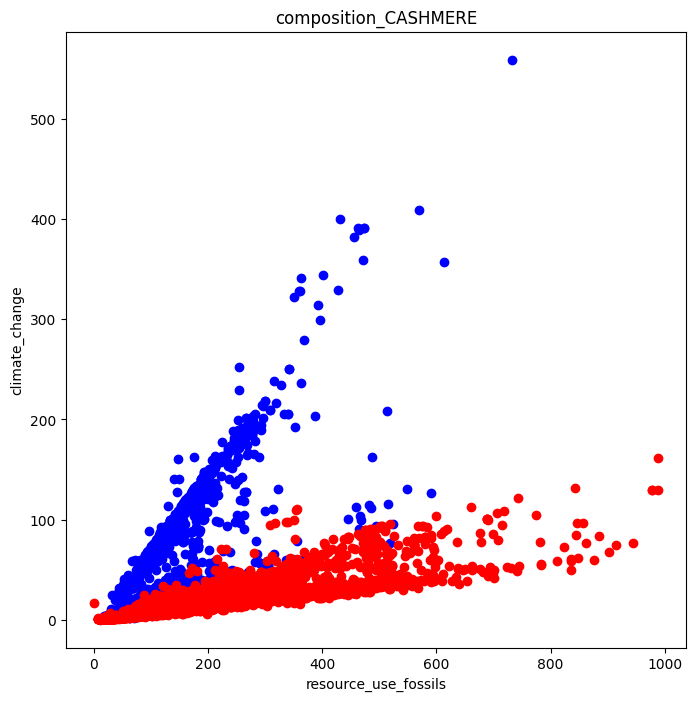

In [25]:
plt.rcParams['figure.figsize']=(8,8)

binary_feature=binary_features[0]
pos_df=df[df[binary_feature]]
neg_df=df[~df[binary_feature]]
x=df['resource_use_fossils']
y=df['climate_change']
x_pos=pos_df['resource_use_fossils']
y_pos=pos_df['climate_change']
x_neg=neg_df['resource_use_fossils']
y_neg=neg_df['climate_change']

global_corr=np.corrcoef(x, y)[0,1]
pos_corr=np.corrcoef(x_pos, y_pos)[0,1]
neg_corr=np.corrcoef(x_neg, y_neg)[0,1]
weighted_corr=len(x_pos)*pos_corr/len(x)+len(x_neg)*neg_corr/len(x)

print("global_corr : %f, pos_corr : %f, neg_corr : %f,weighted_corr : %f"%(global_corr,pos_corr,neg_corr,weighted_corr))

plt.scatter(x_pos,y_pos,c='b')
plt.scatter(x_neg,y_neg,c='r')
plt.xlabel('resource_use_fossils')
plt.ylabel('climate_change')
_=plt.title(binary_feature)

### EXTRACTING AND VISUALIZING LEAF CONFIGURATIONS

In [26]:
t1=time.time()
tree=reg.tree_
n_binary_features=tree.n_features
nx_tree=convert_tree(tree)
FED.compute_features(nx_tree)
leaf_configurations,leaf_values=extract_leaf_configuration(nx_tree)
decoded_configurations=[FED.decode_key_configuration(leaf_configuration) for leaf_configuration in leaf_configurations]
t2=time.time()
print("extracting configurations took %f"%(t2-t1))

extracting configurations took 0.064307


In [27]:
random.choice(decoded_configurations)

{'product_type': {'label': 'FORMAL COATS'},
 'nb_components': {'forbidden_labels': array([2])},
 'composition': {'forbidden_labels': array(['CASHMERE', 'SHEEPWOOL', 'VIRGINWOOL'], dtype='<U33'),
  'mandatory_labels': array(['POLYAMIDE'], dtype='<U33')},
 'raw_material_country': {'forbidden_labels': array([], dtype='<U2'),
  'mandatory_labels': array([], dtype='<U2')},
 'weaving_country': {'forbidden_labels': array([], dtype='<U2'),
  'mandatory_labels': array([], dtype='<U2')},
 'dyeing_country': {'forbidden_labels': array([], dtype='<U2'),
  'mandatory_labels': array([], dtype='<U2')},
 'manufacturing_country': {'forbidden_labels': array([], dtype='<U2'),
  'mandatory_labels': array([], dtype='<U2')},
 'plane_in_transports': None}

### SAVING DATA

In [28]:
model_path="./model.p"
features_encoder_decoder_path="./features_encoder_decoder.p"
leaf_configurations_path="./leaf_configurations.p"
leaf_values_path="./leaf_values.npy"

with open(model_path,"wb") as file:
    pickle.dump(reg,file)
with open(features_encoder_decoder_path,"wb") as file:
    pickle.dump(FED,file)
with open(leaf_configurations_path,"wb") as file:
    pickle.dump(leaf_configurations,file)
np.save(leaf_values_path,leaf_values)